<h1>What Kind of Film Projects Make Profitable Investments?</h1>

<h3>Beyond Box Office Returns</h3>

<p>Looking at the film production space, it's easy to be mesmerized by individual big box office statistics: Franchise movies like the Batman films, MCU and Star Wars can make over a billion dollars worldwide. So does that mean Action and Adventure movies are the most profitable avenues for investment? To answer this question, we'll be looking both at the market size of various film genres as well as their expected returns on investment.</p>

<h1>Two Important Metrics</h1>

<h3>Genre Size</h3>

<p>The size of a film genre can be represented as the sum of the gross earnings for every film belonging to that genre. While this doesn't tell us how profitable the genre is, it does tell us how big the market is for these films. It's important that we know the market size for each genre, so we can set reasonable expectations for how much money can be made in it.</p>

<h3>Expected Return on Investment</h3>

<p>Blockbusters cost a lot to make--with budgets running in the hundreds of millions. And not all big budget movies earn back their production costs. We therefore need to evaluate investment strategies based both on the cost of production and on the uncertainty of returns. The best way to do this is to calculate the expected return on investment for every dollar invested in line with a given strategy. In this particular case, we aggregate returns and costs over entire film genres in order to calculate the expected return per dollar of investments in that genre.</p>
    
<p>Ideally, an Expected Return on Investment statistic would be calculated by including costs for distribution and marketing as well as production. On the profit side, it would include rental and streaming as well as box office earnings. Because the data we have only includes production costs and box office earnings, we will calculate Expected ROI based on only these figures, but we should also think about how other factors not represented in the data might affect our conclusions.</p>

<h1>Data Breakdown</h1>

<h3>By Genre</h3>

<p>In our first level of analysis, we will determine the size of each genre, calculated as the sum of earnings for movies categorized within that genre. We will use this statistic as well as total production costs for each genre to calculated the genre's Expected ROI.</p>

<h3>By Production Size</h3>

<p>In our second level of analysis, we will categorize each genre by production size, measured as the log base 10 of the production costs. A production size of 8 corresponds to a 9-figure production budget--a budget measured in hundreds of millions of dollars--while a budget size of 3 corresponds to a 4-figure production budget--measured in thousands of dollars. As we'll see, 4 and 5 figure productions are not well represented in the data set so we'll only be focusing on 7, 8, and 9 figure productions in our final analysis.</p>


<h1>The Data</h1>

<p>To calculate these statistics, I began with the movie_budgets dataset from the-numbers.com, since it was the only dataset to include both box office grosses and production budgets. This allowed me to calculate the return on investment (ROI) of almost six thousand movies. I then used the IMDB and TMDB databases to add columns with genre labels and filtered on the text in these labels to get statistics on each genre. While I was only able to find genre information for about a third of the movies in movie_budgets, I calculated a series of scaling factors to correct for biases in the smaller data set.</p>

<h1>Wrangling the Data</h1>

<h3>Importing Libraries</h3>

In [1]:
#importing necesary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
import warnings
warnings.filterwarnings('ignore') #disables warning

<h3>Loading the primary dataset</h3>

In [3]:
#loading the movie_budgets data set as a pandas dataframe

movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

In [4]:
#inspecting the movie_budgets dataframe

movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


<h3>Converting dollar values to floats and release_date values to integers. </h3>

In [5]:
def dollars_to_float(d):
    '''
    Converts values in dollars to floats.
    '''
    if type(d) == float:
        pass
    elif type(d) == int:
        return float(d)
    else:
        return float(d.replace('$','').replace(',',''))

In [6]:
#applies dollars_to_float function to dataset

for column in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    movie_budgets[column] = movie_budgets[column].map(dollars_to_float)

In [7]:
#converts release dates to integers

movie_budgets['release_date'] = movie_budgets['release_date'].apply(lambda d: int(d[-4:]) if type(d)==str else d)

<h3>Features of the Data Set</h3>

In [8]:
movie_budgets.describe()

,id,release_date,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,2003.967139,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,12.724386,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1915.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,2000.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,2007.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,2012.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,2020.000000,4.250000e+08,9.366622e+08,2.776345e+09


<p>This data set consists of only 5782 movies made between 1915 and 2020. 75% were made after 2000 which strongly suggests that the pre-2000 data is biased in favor of well-known and therefore more successful movies. This is made clear in the histogram below:</p>

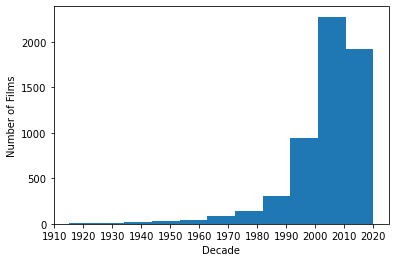

In [9]:
fig, ax = plt.subplots()
ax.hist(movie_budgets['release_date'], bins=11)
ax.set_xticks(np.arange(1910, 2030, 10))
ax.set_xlabel('Decade')
ax.set_ylabel('Number of Films')
plt.show()

<h3>Engineering New Features</h3>
<p>We can assess some of these hypotheses by engineering new features for our data.</p>
<p>The three features I added were Domestic ROI, Worldwide ROI and production size, measured as log base 10 of the production budget.</p>

In [10]:
movie_budgets['domestic_roi'] = (movie_budgets['domestic_gross']-movie_budgets['production_budget'])/movie_budgets['production_budget']
movie_budgets['worldwide_roi'] = (movie_budgets['worldwide_gross']-movie_budgets['production_budget'])/movie_budgets['production_budget']
movie_budgets['production_size'] = (np.log10(movie_budgets['production_budget'])).apply(int)

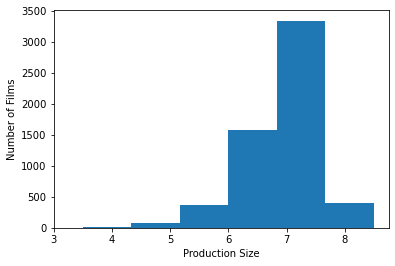

In [11]:
fig, ax = plt.subplots()
ax.hist(movie_budgets['production_size'] +0.5, bins=6)
ax.set_xticks(np.arange(3, 9))
ax.set_xlabel('Production Size')
ax.set_ylabel('Number of Films')
plt.show()

<p>Most movie budgets represented fall into the 10s of millions of dollars range, with a substantial
number in the single millions of dollars range.</p> 

<h3>High Grossing Movies vs. High ROI movies</h3>

<p>The below table shows the top ten highest grossing movies in our data set.</p>

In [12]:
movie_budgets.sort_values('worldwide_gross', ascending=False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,production_size
0,1,2009,Avatar,425000000.0,760507625.0,2.776345e+09,0.789430,5.532577,8
42,43,1997,Titanic,200000000.0,659363944.0,2.208208e+09,2.296820,10.041042,8
5,6,2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,2.060988,5.710167,8
6,7,2018,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.262718,5.827114,8
33,34,2015,Jurassic World,215000000.0,652270625.0,1.648855e+09,2.033817,6.669092,8
66,67,2015,Furious 7,190000000.0,353007020.0,1.518723e+09,0.857932,6.993278,8
26,27,2012,The Avengers,225000000.0,623279547.0,1.517936e+09,1.770131,5.746382,8
3,4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,0.388403,3.243841,8
41,42,2018,Black Panther,200000000.0,700059566.0,1.348258e+09,2.500298,5.741291,8
260,61,2011,Harry Potter and the Deathly Hallows: Part II,125000000.0,381193157.0,1.341693e+09,2.049545,9.733545,8


<p>The top two highest grossing movies are two James Cameron films followed by 8 franchise films. Every one of them was made for 9 figures (production size 8). But what are the top films when we sort our values by return on investment?</p>

In [13]:
movie_budgets.sort_values('worldwide_roi', ascending=False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,production_size
5745,46,1972,Deep Throat,25000.0,45000000.0,45000000.0,1799.000000,1799.000000,4
5613,14,1980,Mad Max,200000.0,8750000.0,99750000.0,42.750000,497.750000,5
5492,93,2009,Paranormal Activity,450000.0,107918810.0,194183034.0,238.819578,430.517853,5
5679,80,2015,The Gallows,100000.0,22764410.0,41656474.0,226.644100,415.564740,5
5406,7,1999,The Blair Witch Project,600000.0,140539099.0,248300000.0,233.231832,412.833333,5
5709,10,2004,Super Size Me,65000.0,11529368.0,22233808.0,176.374892,341.058585,4
5346,47,1942,Bambi,858000.0,102797000.0,268000000.0,118.810023,311.354312,5
5773,74,1993,El Mariachi,7000.0,2040920.0,2041928.0,290.560000,290.704000,3
5676,77,1968,Night of the Living Dead,114000.0,12087064.0,30087064.0,105.026877,262.921614,5
5210,11,1976,Rocky,1000000.0,117235147.0,225000000.0,116.235147,224.000000,6


<p>The top 10 most profitable movies by ROI are quite different from the highest grossing movies.</p>
    
<p>None of these movies have a production size of above 6 (7 figures), even when we adjust for inflation.</p>
    
<p>It's not surprising that low budget hits top this list or that horror films (notoriously cheap to produce) dominate. However, these breakout successes probably aren't representative of the profitability of their genres as a whole.</p>


<h3>Function for Aggregating Data</h3>
<p>In order to determine the overall profitability of investing in various genres, we will be calculating aggregate  production costs and earnings for movies by genre in the data set. From these figures, we'll calculate expected domestic and worldwide ROI for investment by genre.</p>
<p>However, before we break the data set down by genre, we'll define our aggregating function and calculate the Expected ROI for movies across our entire data set.</p>

In [14]:
def get_aggregate_data(df):
    
    '''
    Returns a dictionary of aggregate data for the requested dataframe: 
    -Total Films in the dataset belonging to genre
    -
    '''
    
    aggregates = {}
    aggregates['total_films'] = df.shape[0]
    aggregates['investment_in_production'] = df['production_budget'].sum()
    aggregates['domestic_gross'] = df['domestic_gross'].sum()
    aggregates['worldwide_gross'] = df['worldwide_gross'].sum()
    
    aggregates['expected_domestic_roi'] = (aggregates['domestic_gross']-aggregates['investment_in_production'])/aggregates['investment_in_production']
    aggregates['expected_worldwide_roi'] = (aggregates['worldwide_gross']-aggregates['investment_in_production'])/aggregates['investment_in_production']
    
    return aggregates

get_aggregate_data(movie_budgets)

{'total_films': 5782,
 'investment_in_production': 182640411532.0,
 'domestic_gross': 242111575945.0,
 'worldwide_gross': 528980498961.0,
 'expected_domestic_roi': 0.32561886996504164,
 'expected_worldwide_roi': 1.896294935627204}

<p>As we see here, the  5782 films in the data set represent over \$180 billion of investment in production and almost $529 billion in gross earnings. Someone owning equally sized shares of each of these movies would have realized a 190% return on their investments, not factoring in marketing/distribution costs and earnings from rentals and streaming.</p>

<h2>Getting Genre Data</h2>
<p>In order to get genre data, I loaded two additional datasets: tmdb and imdb.</p>

In [15]:
tmdb = pd.read_csv('data/tmdb.movies.csv', index_col=0)

In [16]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


<p>Because this dataset has more information than we need, I sliced it to include only genre_ids, title, and release date. I included release date, because there are multiple movies with the same name, so I needed to keep this feature to accurately merge this dataset with the budgets dataset. I also dropped duplicates to avoid merging multiple lines of genre information with single lines of budget and earnings information.</p>

In [17]:
#Picks out the title, genre and date information from tmdb

tmdb_sliced = tmdb[['genre_ids', 'title', 'release_date']]

#converts dates to integers

tmdb_sliced['release_date'] = tmdb_sliced['release_date'].apply(lambda d: int(d[:4]) if type(d)==str else d)

#drops duplicates where title and release date are the same.

tmdb_sliced.drop_duplicates(subset=['title', 'release_date'], inplace=True)

In [18]:
#renames title column in preparation for merge with budgets dataset.

tmdb_sliced.rename(columns={'title':'movie'}, inplace=True)

<h3>First merge - TMDB</h3>
<p>Here I merge the sliced tmdb dataset with the original budgets dataset. I performed a left merge because I was only interested in movies for which I can calculate ROI. I didn't perform an inner merge because I wanted to keep all the rows in the original data in case I found genre information for them later.</p>

In [19]:
#joins genre information from tmdb to budgets database

budgets_genres = movie_budgets.merge(tmdb_sliced, how='left', on=['movie', 'release_date'])

In [20]:
budgets_genres.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,production_size,genre_ids
0,1,2009,Avatar,425000000.0,760507625.0,2.776345e+09,0.789430,5.532577,8,"[28, 12, 14, 878]"
1,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,-0.412899,1.546673,8,"[12, 28, 14]"
2,3,2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-0.877822,-0.572108,8,NaN
3,4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,0.388403,3.243841,8,"[28, 12, 878]"
4,5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,0.956408,3.153696,8,NaN


<p>We now have a single additional column, which includes lists of genre id numbers as strings. There are still 5782 rows in our dataset. However, many of these rows have genre listed as NaN</p>

In [21]:
budgets_genres[budgets_genres['genre_ids'].isna()==False].shape[0]

1600

<h3>Using SQLite to query the IMDB database</h3>

<p>Unfortunately, we were only able to get 1600 rows of genre id information from the TMDB data set. To supplement this data I turned to a second dataset, IMDB, which needed to be queried using SQL.</p>

In [22]:
#opens connection to imdb database
conn = sqlite3.connect('data/im.db')

In [23]:
#retrieves title, genre, and year information from imdb database as dataframe.

q='''
SELECT primary_title, genres, start_year FROM movie_basics;
'''
imdb = pd.read_sql(q, conn)

conn.close()

In [24]:
imdb.head()

,primary_title,genres,start_year
0,Sunghursh,"Action,Crime,Drama",2013
1,One Day Before the Rainy Season,"Biography,Drama",2019
2,The Other Side of the Wind,Drama,2018
3,Sabse Bada Sukh,"Comedy,Drama",2018
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy",2017


<h3>Second Merge - IMDB</h3>

In [25]:
#renames columns in imdb dataframe so it can be joined to budgets_genres dataframe

imdb.rename(columns={'primary_title':'movie','start_year':'release_date'}, inplace=True)

In [26]:
#drops duplicates from imdb dataframe

imdb.drop_duplicates(subset=['movie', 'release_date'], inplace=True)

In [27]:
#merges imdb dataframe with budgets_genres dataframe

budgets_genres = budgets_genres.merge(imdb, how='left', on=['movie', 'release_date'])

<h3>Inspecting our data set to see the number of rows with genre information</h3>

In [28]:
budgets_genres[(budgets_genres['genre_ids'].isna()==False)|(budgets_genres['genres'].isna()==False)].shape[0]

1725

<p>The imdb database gave us an additional 125 genre labels giving us a total sample of 1725 movies with genre labels that we can analyze. While there's a possibility that this sample (as well as our original dataset) may be biased in some way, it does include the widest range of ROI statistics for movies labeled by genre given the datasets available.</p>

<h1>Evaluating our new Genres and Budgets Data Set</h1>

<h3>How does the sample of data for which we have genre values differ from the dataset as a whole?</h3>

In [29]:
#creates a new data set for only movies where genre information is available
bg = budgets_genres[(budgets_genres['genre_ids'].isna()==False)|(budgets_genres['genres'].isna()==False)]
bg.describe()

,id,release_date,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,production_size
count,1725.000000,1725.000000,1.725000e+03,1.725000e+03,1.725000e+03,1725.000000,1725.000000,1725.000000
mean,50.728696,2013.255072,4.165854e+07,5.266504e+07,1.311471e+08,0.864402,2.667177,6.746087
std,28.717633,4.768770,5.461766e+07,8.359872e+07,2.321300e+08,6.427358,11.727822,0.796886
min,1.000000,1946.000000,1.500000e+04,0.000000e+00,0.000000e+00,-1.000000,-1.000000,4.000000
25%,26.000000,2011.000000,6.000000e+06,1.477002e+06,4.816142e+06,-0.813413,-0.476010,6.000000
50%,51.000000,2014.000000,2.000000e+07,2.414939e+07,4.340252e+07,-0.143307,0.945704,7.000000
75%,76.000000,2016.000000,5.000000e+07,6.379566e+07,1.427837e+08,0.846013,2.913840,7.000000
max,100.000000,2020.000000,4.250000e+08,7.605076e+08,2.776345e+09,226.644100,415.564740,8.000000


<p>In this data set, 75% of dates in the list are from 2011 or later, while in the larger list 75% of dates are from 2000 or later. This bias of the data towards more recent movies is probably good because newer movies are more representative of current market conditions.</p>

<h3>Trimming the data set to make it more uniform</h3>
<p>Since there are so few dates before 2000, I'm going to drop them from the data set altogether. This will make it clear that the data we are looking at applies to the period from 2000-2020. </p>

In [30]:
bg=bg[bg['release_date']>=2000]
bg.shape[0]

1691

<p>We've lost 34 values, but the data is now a more representative sample of the last 20 years rather than an extremely unrepresentative sample of the past 75 years.</p>

<h1>Identifying and Adjusting for Bias</h1>
<h3>Identifying Bias</h3>
<p>To determine how biased our new data set is I compared aggregate statistics from this data set with aggregate data for all movies in the-numbers database since 2000.</p>

In [31]:
after_2000_data = budgets_genres[budgets_genres['release_date']>=2000]
get_aggregate_data(after_2000_data)

{'total_films': 4387,
 'investment_in_production': 151387608606.0,
 'domestic_gross': 183513027791.0,
 'worldwide_gross': 425241551042.0,
 'expected_domestic_roi': 0.21220639840219235,
 'expected_worldwide_roi': 1.8089587711813968}

In [32]:
get_aggregate_data(bg)

{'total_films': 1691,
 'investment_in_production': 70692979123.0,
 'domestic_gross': 87690636874.0,
 'worldwide_gross': 219990231811.0,
 'expected_domestic_roi': 0.24044336455852944,
 'expected_worldwide_roi': 2.1119106103625227}

<p>I then calculated the ratio of the smaller data set to the full post-2000 data set.</p>

In [33]:
full=get_aggregate_data(after_2000_data)
small=get_aggregate_data(bg)
full_small_ratio_dict = {}
for key in full.keys():
    full_small_ratio_dict[key]=small[key]/full[key]
    
for key in full_small_ratio_dict.keys():
    print(key, ': ', full_small_ratio_dict[key])

total_films :  0.3854570321404149
investment_in_production :  0.4669667469745486
domestic_gross :  0.47784420501126185
worldwide_gross :  0.5173300475269693
expected_domestic_roi :  1.133063688790476
expected_worldwide_roi :  1.1674730480359559


<h3>Correcting for bias</h3>

<p>Even though our data represents  38.5% of the full post-2000 dataset, it represents 46.7% of the original data set's investment in production, 47.8% of the original dataset's domestic gross and 51.7% of the original dataset's worldwide gross. Expected Domestic ROI is larger by a factor of 1.13, while expected worldwide roi is larger by a factor of 1.16.</p>

<p>This suggests that movies with genre information available have both larger budgets and are more successful than movies without genre information available. In order to correct for this bias, we create a scaling dictionary below that determines the factor by which statistics for each production size in the larger data are scaled in the smaller biased data set. We can then divide the statistics for the smaller data set by this scaling factor in order to correct  our bias.</p>

In [34]:
scaling_dictionary = {}

for n in range (4,9):
    after_2000_n=after_2000_data[after_2000_data['production_size']==n]
    b_n=bg[bg['production_size']==n]
    after_2000_n_aggs = get_aggregate_data(after_2000_n)
    b_n_aggs = get_aggregate_data(b_n)
    ratio = {}
    for key in after_2000_n_aggs.keys():
        ratio[key]=b_n_aggs[key]/after_2000_n_aggs[key]
    scaling_dictionary[n] = ratio
    print (n)
    for key, value in scaling_dictionary[n].items():
        print(key, ': ', value)

4
total_films :  0.3898305084745763
investment_in_production :  0.4458981774778497
domestic_gross :  0.03357338605199888
worldwide_gross :  0.03859377689072525
expected_domestic_roi :  -0.05750804255891136
expected_worldwide_roi :  0.011932965548289813
5
total_films :  0.3055555555555556
investment_in_production :  0.3028273874362804
domestic_gross :  0.20566032017623642
worldwide_gross :  0.17777847912172126
expected_domestic_roi :  0.5446830778426108
expected_worldwide_roi :  0.49837734827298785
6
total_films :  0.36211453744493394
investment_in_production :  0.3516550427206872
domestic_gross :  0.4647877008368131
worldwide_gross :  0.447469430992875
expected_domestic_roi :  1.7813116789047565
expected_worldwide_roi :  1.3894059585716094
7
total_films :  0.37604456824512533
investment_in_production :  0.3761901193285541
domestic_gross :  0.40649905819023757
worldwide_gross :  0.4277599490392841
expected_domestic_roi :  1.4287638614861378
expected_worldwide_roi :  1.2264132992524803
8

<p>These numbers are the factors by which data in each of these categories has been scaled by the bias of the new data set. For example it appears that the number of 9 budget films has been scaled down less than the number of 6 figure films, since 58.3% of the 9 figure movies made it into the final data set whereas only 30.6% of 6 figure films made it in. </p>
<p>Similarly, Expected Worldwide ROI for 9 figure films was scaled up, while Expected Domestic ROI for 9 figure films was scaled down. This suggests that the kind of 9 figure movies represented in the smaller data set tend to be those that made a greater proportion of their profits overseas, while 9 figure movies that made less profit overseas are underrepresented.</p>

<p>In general, Expected ROI for bigger (7 to 9 figure) movies is magnified in the smaller data set, whereas aggregate ROI for smaller movies is scaled down by the smaller data set. Assuming that the original data set is unbiased, it seems like this smaller data set is biased in favor of the profitability of 7 and 8 figure movies and against the profitability of 5 and 6 figure movies. There's a chance though, that many 5 and 6 figure movies aren't represented on the original list, because of their low level of visibility. This would make the larger list biased <b>in favor</b> of the profitability of these movies, which means that our correction factor might end up actually increasing our data's bias. The likelihood of this being the case is an argument for cutting these movies from our analysis all together.</p>


<h1>Pulling out information from our dataset by genre</h1>
<p>In order to get statistics on each genre we need to define a dictionary of genres that will allow us to query the database for movies by genre. Next, we need to define a function that returns a dictionary of aggregate statistics based on our query. The following genre dictionary uses keys that correspond to IMDB genre labels and values that correspond to the genre IDs found in the TMDB database.</p>

In [35]:
genre_dictionary = {'Action': '28', 'Adventure': '12', 'Animation': '16', 'Comedy': '35', 'Crime': '80', 'Documentary': '99',\
 'Drama': '18', 'Family': '10751', 'Fantasy': '14', 'History': '36', 'Horror': '27', 'Music': '10402', \
 'Mystery': '9648', 'Romance': '10749', 'Sci-Fi': '878', 'Thriller': '53', \
 'War': '10752', 'Western': '37'}

In [36]:
def get_data_by_genre(genre):
    
    '''
    Returns a dictionary of aggregate data for the requested genre. The function filters for data that
    includes either the genre key (since the imdb columns 'genres' includes genre names) or the numeric genre value
    as a string (since this is how genres are designated in the tmdb dataset).
    
    '''
    
    bg_filtered = bg[(bg['genre_ids'].str.contains(genre_dictionary[genre])==True)\
                                           |(bg['genres'].str.contains(genre))]
    return get_aggregate_data(bg_filtered)


<h3>Compiling Expected ROI data by genre</h3>

In [37]:
#Creates a dictionary of genres, with values as roi data calculated using the get_data_by_genre function using the overall scaling ratio above for worldwide roi.
worldwide_roi_by_genre = {}
for genre in genre_dictionary:
    worldwide_roi_by_genre[genre] = get_data_by_genre(genre)['expected_worldwide_roi']/full_small_ratio_dict['expected_worldwide_roi']

<h3>Plotting Expected ROI data by Genre</h3>

In [38]:
#generates tuples of roi genres and sorts by value from highest to lowest
genre_roi_tuples = zip(list(worldwide_roi_by_genre.keys()), list(worldwide_roi_by_genre.values()))
sorted_genre_roi_tuples = sorted(genre_roi_tuples, key=lambda x: x[1], reverse=True)

#Creates values and labels for plotting
x_values = range(len(sorted_genre_roi_tuples))
x_labels = [x[0] for x in sorted_genre_roi_tuples]
y_values = [x[1] for x in sorted_genre_roi_tuples]                                 

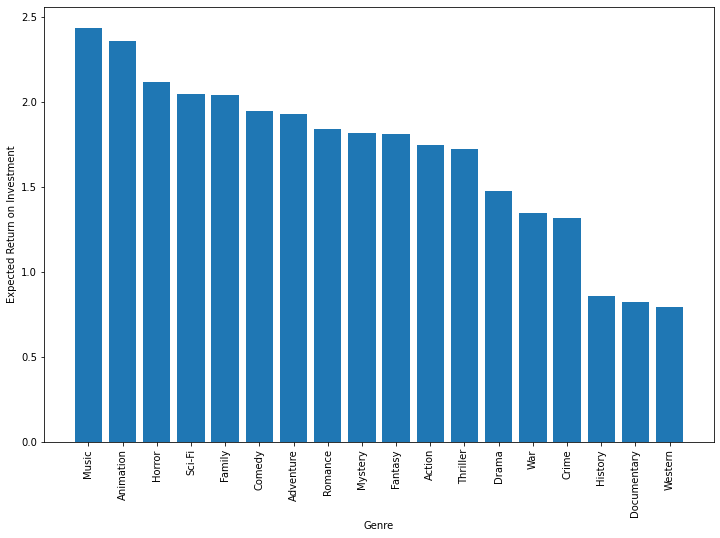

In [39]:
#generates plot for roi values by genre
fig, ax=plt.subplots(figsize=(12, 8))
ax.bar(x_values, y_values)
ax.set_xticks(x_values)
ax.set_xticklabels(x_labels, rotation=90)
ax.set_xlabel('Genre')
ax.set_ylabel('Expected Return on Investment')
plt.show()

<p>According to this data, Music and Animation genres have the highest ROI (almost 3.0) while History, Documentary and Western have the lowest (under 1.0). However, high rates of profit don't necessarily mean that we should invest all our money in these projects. If the market for them is limited, overinvestment could be disastrous. So we also need to look at each genre's worldwide gross.</p>

<h3>Plotting Worldwide Gross by Genre</h3>

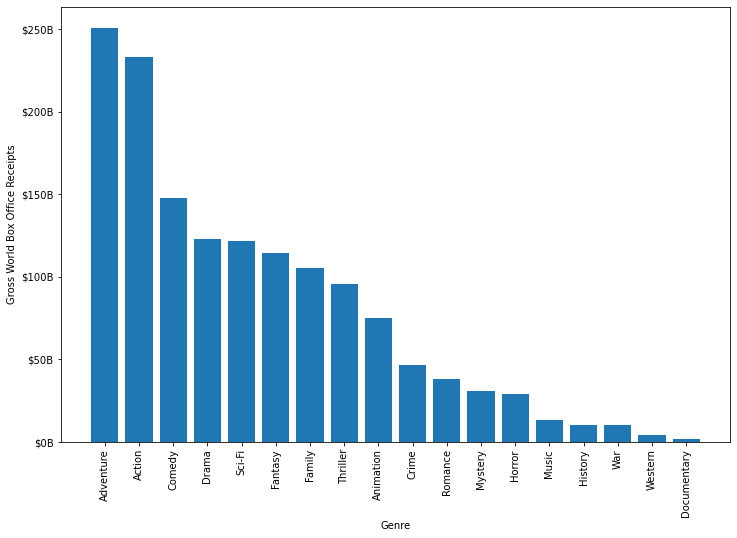

In [40]:
#imports function formatter

from matplotlib.ticker import FuncFormatter

#function to format dollar values to billions

def billions(x,pos):
    return f"${x*1e-9:.0f}B"

price_fmt_bill = FuncFormatter(billions)

#Creates a dictionary of genres, with values as roi data calculated using the get_data_by_genre function and scaled up to estimate values for the larger data set.

worldwide_gross_by_genre = {}
for genre in genre_dictionary:
    worldwide_gross_by_genre[genre] = get_data_by_genre(genre)['worldwide_gross']/full_small_ratio_dict['worldwide_gross']

#generates tuples of roi genres and sorts by value from highest to lowest
genre_gross_tuples = zip(list(worldwide_gross_by_genre.keys()), list(worldwide_gross_by_genre.values()))
sorted_genre_gross_tuples = sorted(genre_gross_tuples, key=lambda x: x[1], reverse=True)

#Creates values and labels for plotting
x_values = range(len(sorted_genre_gross_tuples))
x_labels = [x[0] for x in sorted_genre_gross_tuples]
y_values = [x[1] for x in sorted_genre_gross_tuples]


#generates plot for roi values by genre
fig, ax=plt.subplots(figsize=(12, 8))
ax.bar(x_values, y_values)
ax.set_xticks(x_values)
ax.set_xticklabels(x_labels, rotation=90)
ax.yaxis.set_major_formatter(price_fmt_bill)

ax.set_xlabel('Genre')
ax.set_ylabel('Gross World Box Office Receipts')
plt.show()

<p>Adventure and action take up by far the largest share of the global box office.</p>
<br>
<p>nb. These categories are overlapping so multiple genres may be included in the statistics for each category</p>

[2151784.9297975833, 245579151.27359173, 13927891966.538778, 183017768317.55386, 228048159821.70395]


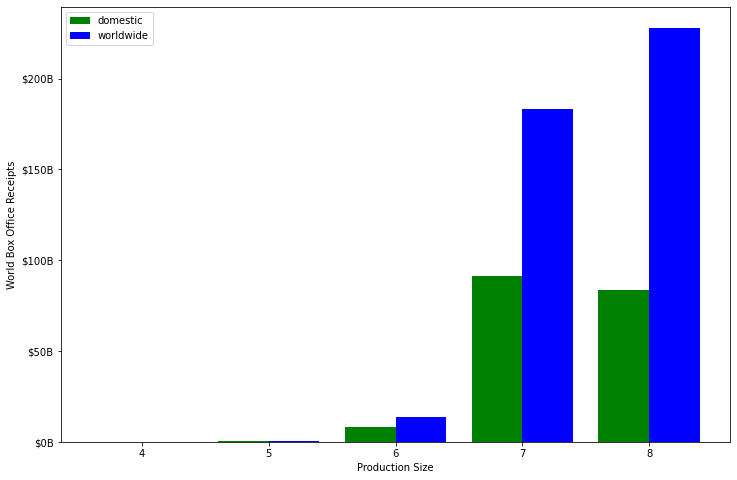

In [41]:
#Creates a dictionary of genres, with values as roi data calculated using the get_data_by_genre function and scaled up to estimate values for the larger data set.
worldwide_gross_by_production_size = []
domestic_gross_by_production_size = []

for size in range(4,9):
    bg_at_size=bg[bg['production_size']==size]
    
    worldwide_gross_at_size = get_aggregate_data(bg_at_size)['worldwide_gross']
    worldwide_gross_by_production_size.append(worldwide_gross_at_size/full_small_ratio_dict['worldwide_gross'])

    domestic_gross_at_size = get_aggregate_data(bg_at_size)['domestic_gross']
    domestic_gross_by_production_size.append(domestic_gross_at_size/full_small_ratio_dict['domestic_gross'])
print(worldwide_gross_by_production_size)
  
#Creates values and labels for plotting
x_values = np.arange(4, 9)

#generates plot for roi values by genre
fig, ax=plt.subplots(figsize=(12, 8))

ax.set_xlabel('Production Size')
ax.set_ylabel('World Box Office Receipts')
ax.bar(x_values -0.2, domestic_gross_by_production_size, color='g', width=0.4, label='domestic')
ax.bar(x_values +0.2, worldwide_gross_by_production_size, color='b', width=0.4, label='worldwide')
ax.yaxis.set_major_formatter(price_fmt_bill)
ax.legend()
plt.show()


<p>We can see here that films of production size of 4 and 5 make no substantial contribution to worlwide gross. So for the next section in which we look at ROI by production size, we'll be disregarding these very small productions and only looking at productions made for 7 figures or more.</p>

<h1>For each genre, what is the Expected ROI by production size?</h1>

<p>The above charts show the profitability and size of various film genres. They do not, however, give us any information about the ideal size for projects in each genre. To determine this, we're going to look at a series of visualizations that shows both the market share and profitability of different sized films in each genre.</p> 
<p>First, we define a function that returns a table filtered by genre.</p>

In [42]:
def get_df_by_genre(genre):
    '''
    Given a genre name, returns a data frame with all movies labeled as that genre.
    '''
    return bg[(bg['genre_ids'].str.contains(genre_dictionary[genre]))|(bg['genres'].str.contains(genre))]

<p>Next, we define a function that gives us bar plots of gross receipts and Expected ROI by production size. The function also returns the number of values for each production size.</p>

In [43]:
def genre_graphs(genre):
    '''
    Makes a series of paired graphs for each genre. Each pair of graphs shows (1)the domestic and worldwide gross for each
    production size, as well (2) as the domestic and worldwide ROI for each production size.
    '''
    
    df = get_df_by_genre(genre)
    df['total'] = 1
    grouped = df[['production_size','production_budget','domestic_gross','worldwide_gross', 'total']].groupby('production_size').sum()
    grouped['domestic_roi'] = (grouped['domestic_gross']-grouped['production_budget'])/grouped['production_budget']
    grouped['worldwide_roi'] = (grouped['worldwide_gross']-grouped['production_budget'])/grouped['production_budget']
    
    grouped=grouped.loc[6:8,]
    
    min_size=6
    max_size=8

    x_values = np.arange(min_size, max_size+1)
    
    #domestic gross list by production size
    y_values_d_gross = list(grouped['domestic_gross'])
    
    #adjusts domestic gross by scaling factor for each production size
    for n in range(len(x_values)):
        y_values_d_gross[n] = y_values_d_gross[n]/scaling_dictionary[n+min_size]['domestic_gross']
        
    #worldwide gross list by production size
    y_values_w_gross = list(grouped['worldwide_gross'])
    
    #adjusts domestic gross by scaling factors
    for n in range(len(x_values)):
        y_values_w_gross[n] = y_values_w_gross[n]/scaling_dictionary[n+min_size]['worldwide_gross']
    
    #domestic roi by production size
    y_values_d_roi = list(grouped['domestic_roi'])
    
    #adjusts domestic roi by scaling factors
    for n in range(len(x_values)):
        y_values_d_roi[n] = y_values_d_roi[n]/scaling_dictionary[n+min_size]['expected_domestic_roi']
    
    #worldwide roi by production size
    y_values_w_roi = list(grouped['worldwide_roi'])
    
    #adjusts worldwide roi by scaling factors
    for n in range(len(x_values)):
        y_values_w_roi[n] = y_values_w_roi[n]/scaling_dictionary[n+min_size]['expected_worldwide_roi']
    
    
    #creates figures for plots
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    
    fig.suptitle(genre, fontsize=16)
    
    #figure for gross plots
    ax1.bar(x_values -0.2, y_values_d_gross, color='g', width=0.4, label='domestic')
    ax1.bar(x_values +0.2, y_values_w_gross, color='b', width=0.4, label='worldwide')
    ax1.set_xticks(np.arange(min_size, max_size+1))
    ax1.set_xticklabels(np.arange(min_size, max_size+1))
    ax1.set_xlabel('Size of Production')
    ax1.set_ylabel('Aggregate Gross Receipts')
    ax1.yaxis.set_major_formatter(price_fmt_bill)
    ax1.set_ylim(0,200000000000)
    ax1.legend()
    ax1.set_title('Aggregate Gross Receipts by Production Size')
    
    
    #figure for roi plots
    ax2.bar(x_values -0.2, y_values_d_roi, color='g', width=0.4, label='domestic')
    ax2.bar(x_values +0.2, y_values_w_roi, color='b', width=0.4, label='worldwide')
    ax2.set_xticks(np.arange(min_size, max_size+1))
    ax2.set_xticklabels(np.arange(min_size, max_size+1))
    ax2.set_xlabel('Size of Production')
    ax2.set_ylim(-1, 8)
    ax2.set_ylabel('Expected Return on Investment')
    ax2.legend()
    ax2.set_title('Expected ROI by Production Size')
    fig.tight_layout()
    plt.show()
    print(grouped[['total']].transpose())

<h3>Finally, we execute our function</h3>
<p>In the series of charts below, the left charts indicates the current size of the market for films of various production budgets, while the right chart indicates how profitable films at each level of investment are likely to be. The charts are sorted from largest market size to smallest market size.</p>

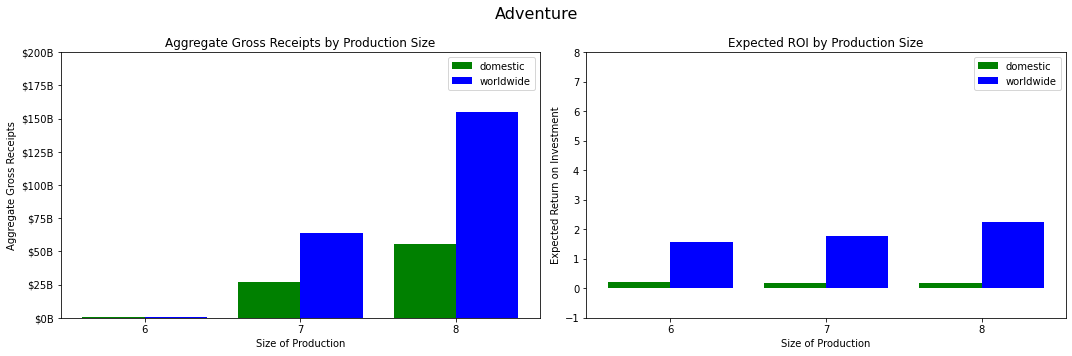

production_size   6    7    8
total            26  170  175


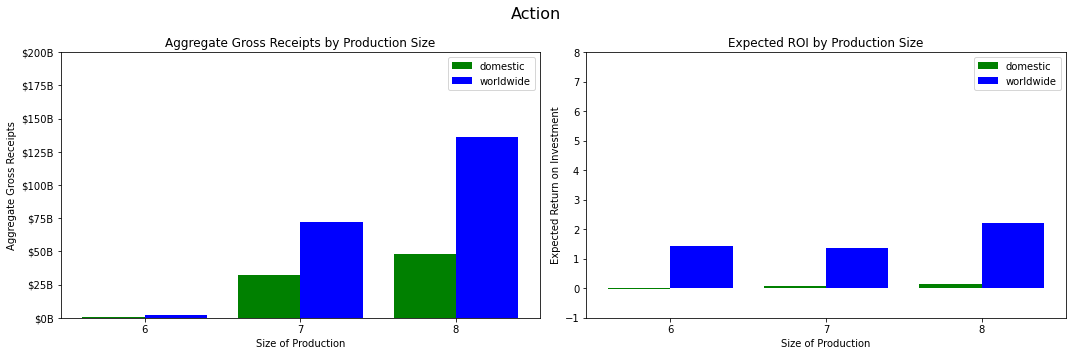

production_size   6    7    8
total            58  269  157


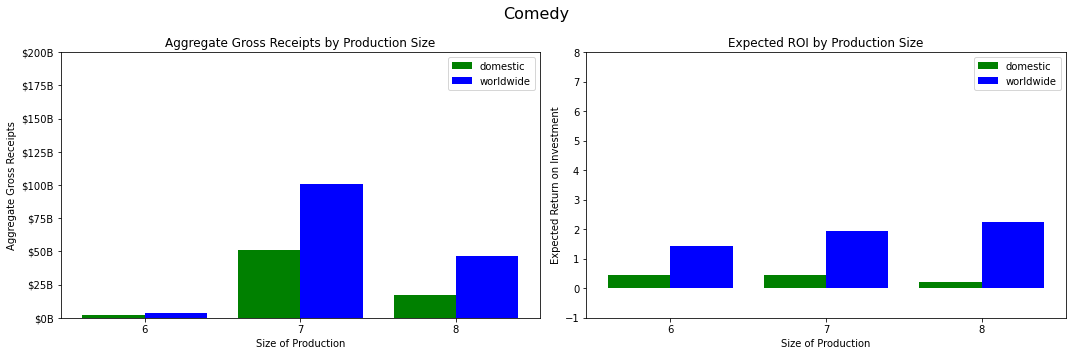

production_size    6    7   8
total            122  351  61


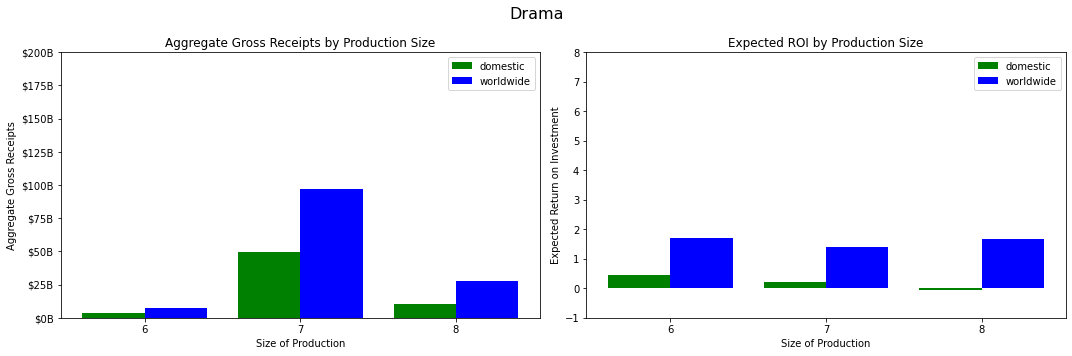

production_size    6    7   8
total            231  511  44


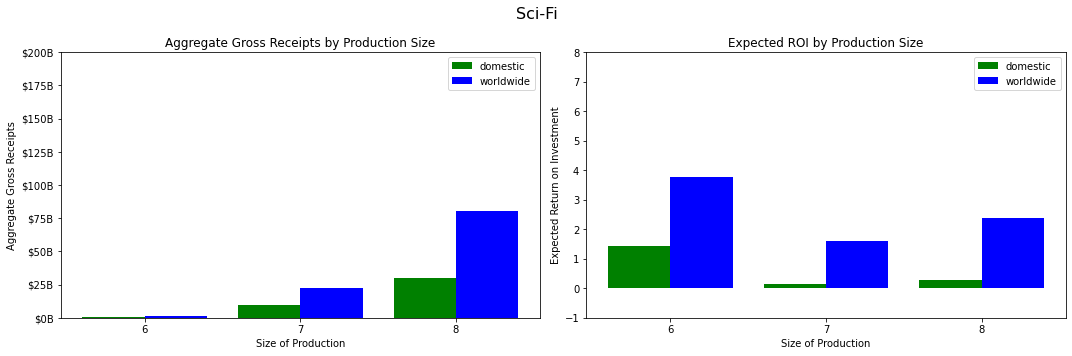

production_size   6   7   8
total            26  83  86


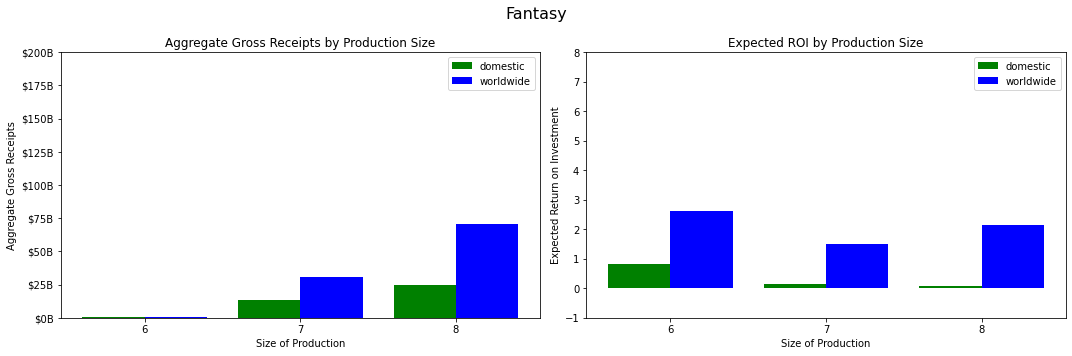

production_size   6   7   8
total            20  90  81


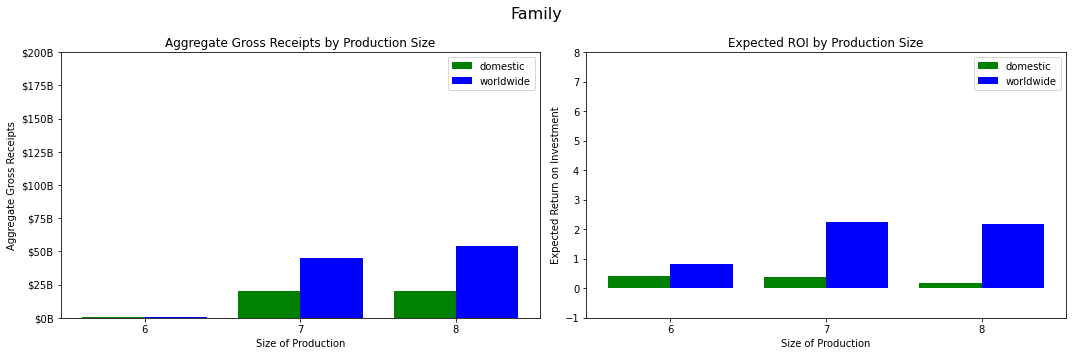

production_size   6    7   8
total            19  105  67


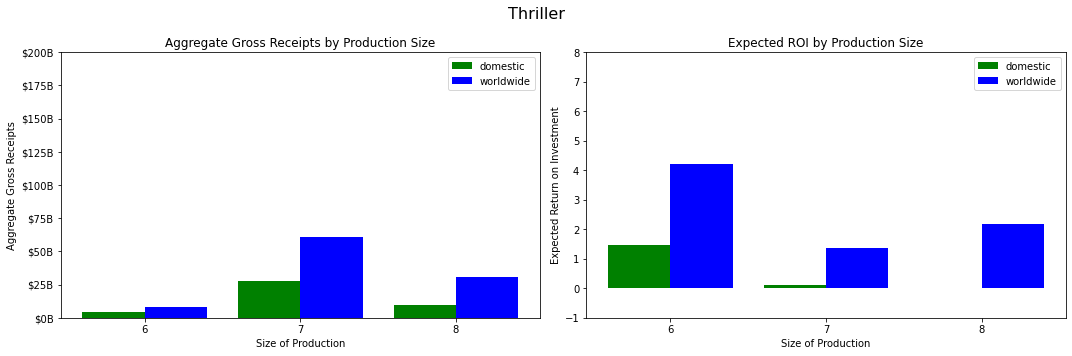

production_size    6    7   8
total            126  290  39


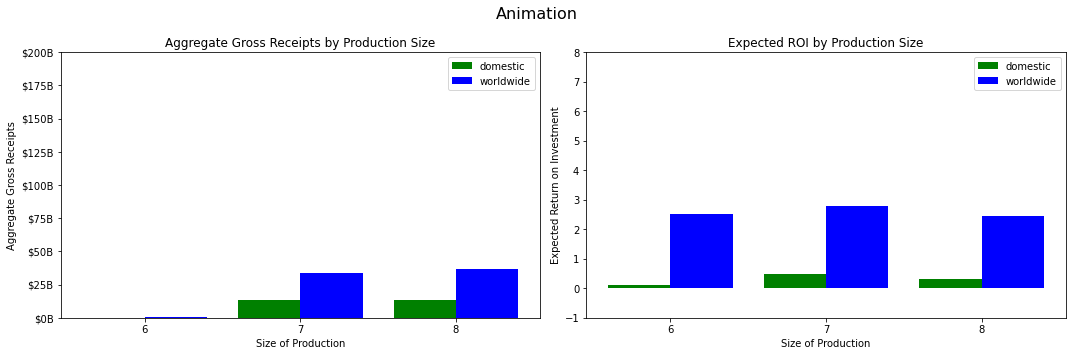

production_size  6   7   8
total            6  55  43


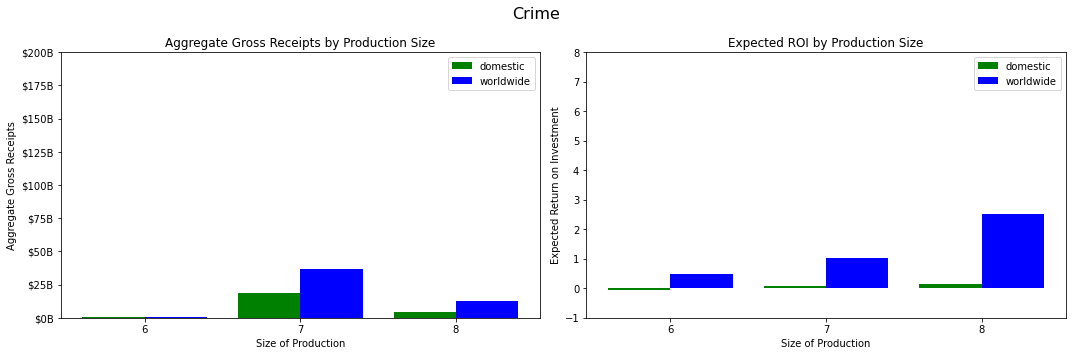

production_size   6    7   8
total            53  201  14


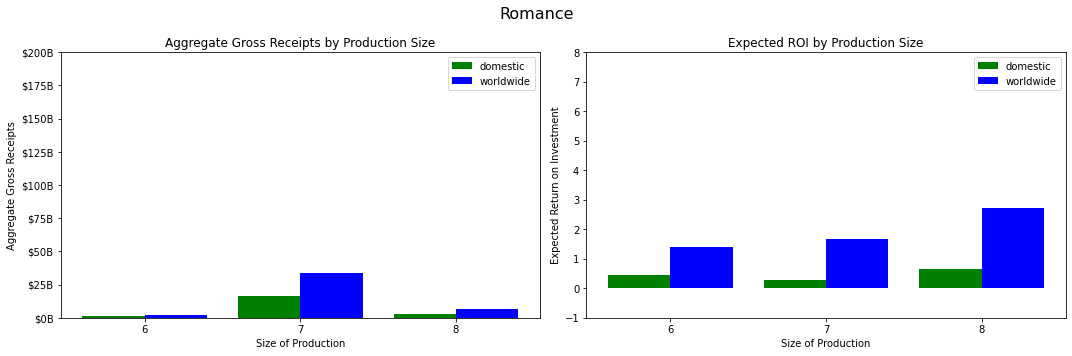

production_size   6    7  8
total            70  151  8


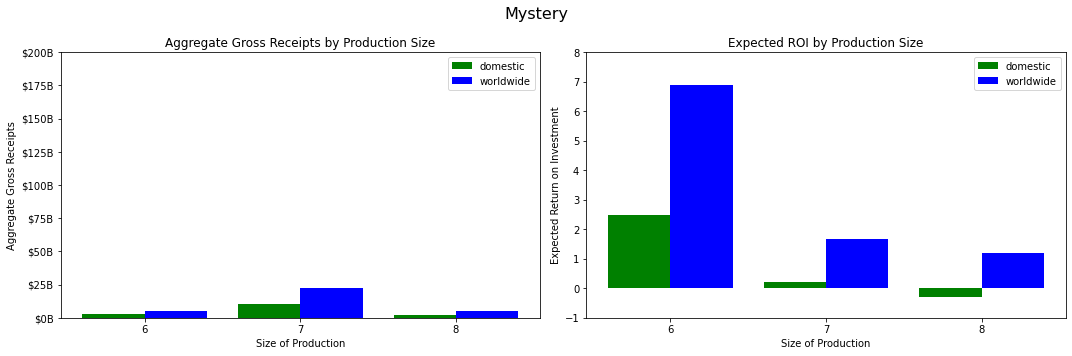

production_size   6    7   8
total            54  100  11


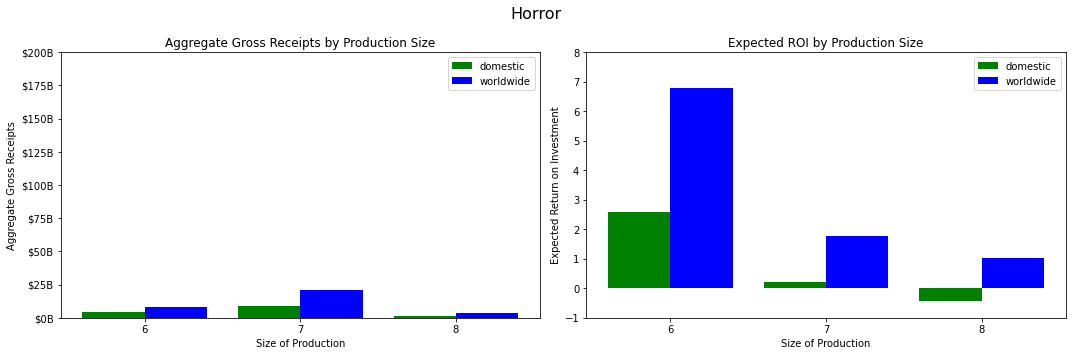

production_size   6   7  8
total            92  98  6


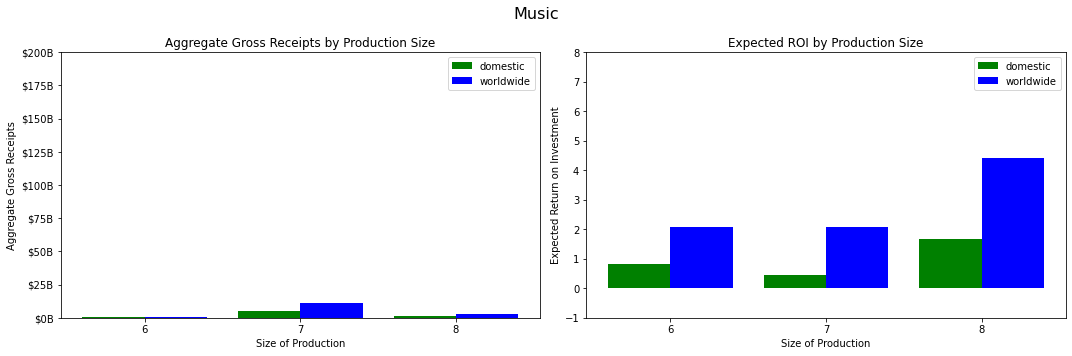

production_size   6   7  8
total            15  41  2


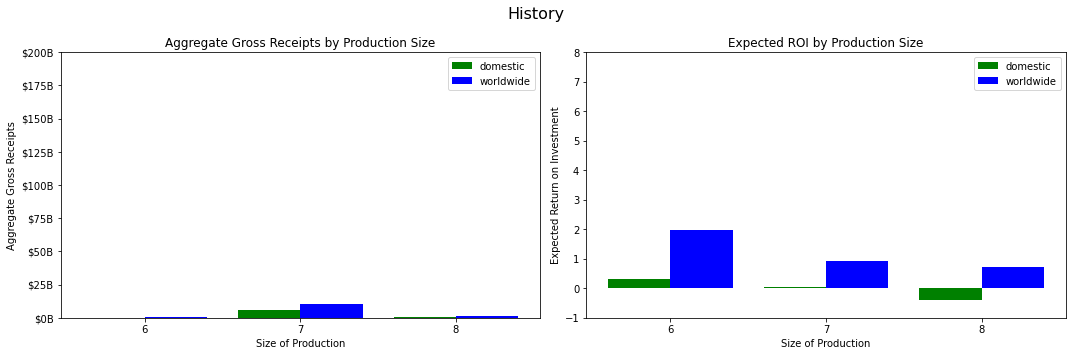

production_size  6   7  8
total            9  66  3


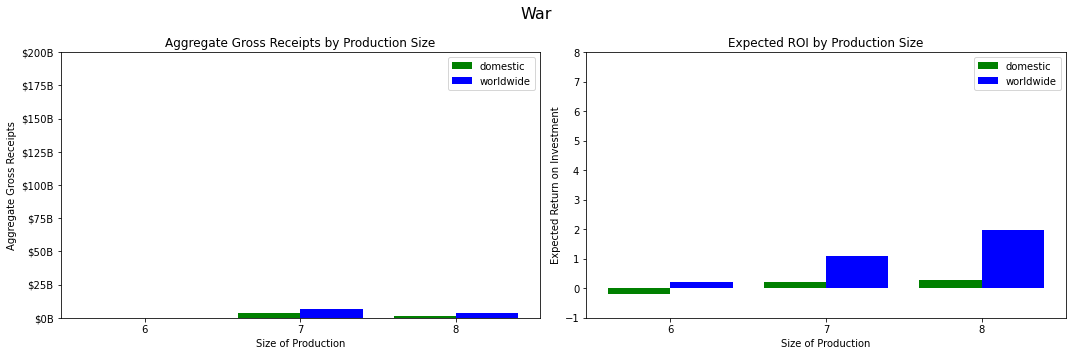

production_size  6   7  8
total            7  34  6


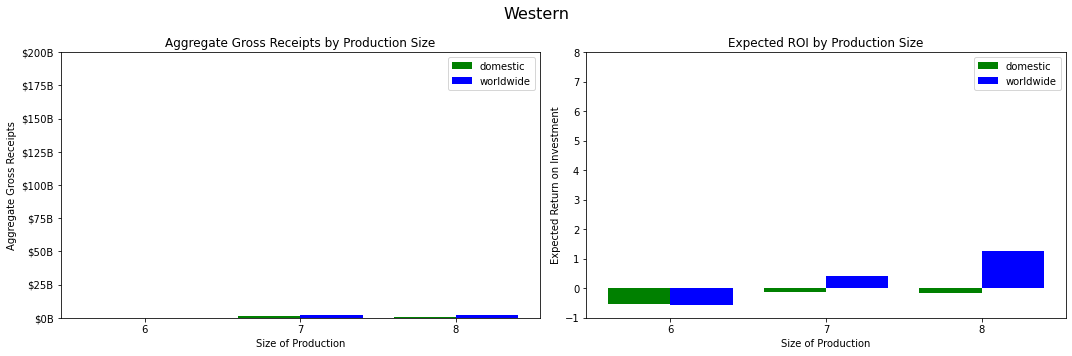

production_size  6   7  8
total            5  12  4


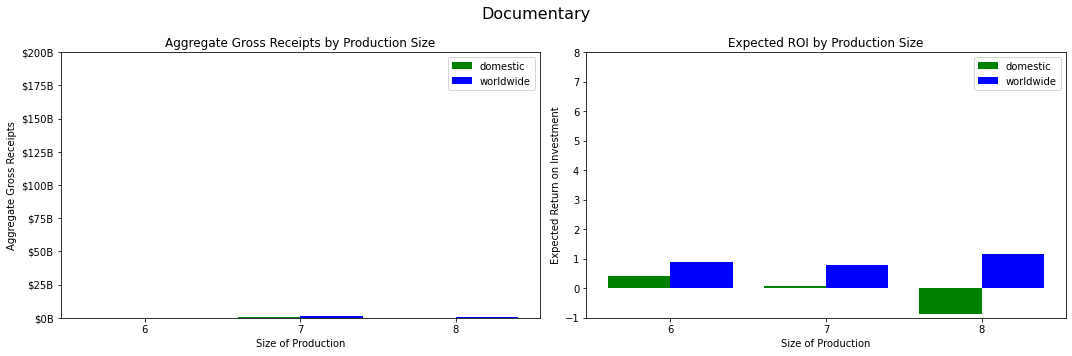

production_size   6  7  8
total            16  8  1


In [44]:
#executes the above function on a list of genres sorted by total worldwide gross
for x in sorted_genre_gross_tuples:
    genre_graphs(x[0])

<h1>Trends</h1>

<p>We can break down these genre categories by whether ROI is ascending as production costs increase as well as by whether medium or large budget movies dominate the global market.</p>

<h2>Ascending ROI</h2>

<h3>Ascending ROI, Big Budgets Dominate:</h3>
<h4>Adventure, Action, Sci-Fi, Fantasy</h4>
<p>In this category, big budget productions dominate medium budgets at the box office and higher levels of investment are correlated with higher rates of return. Low budget Fantasy and Sci-Fi can have a high ROI but they make up a miniscule share of the market.</p>

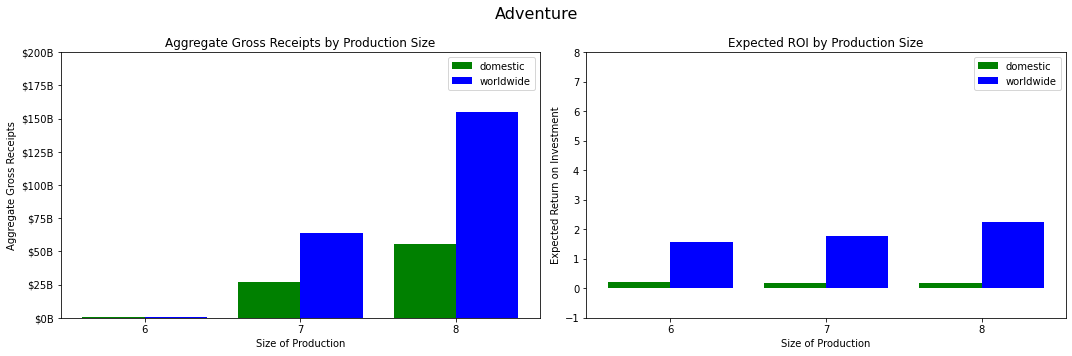

production_size   6    7    8
total            26  170  175


In [45]:
genre_graphs('Adventure')

<h3>Ascending ROI, Medium Budgets Dominate:</h3>
<h4>Comedy, Drama, Thriller, Crime, Romance, Music, War, Western, Documentary</h4>
<p>In this second category, medium budget movies dominate the global box offices, but big budget movies have a higher expected ROI. </p>

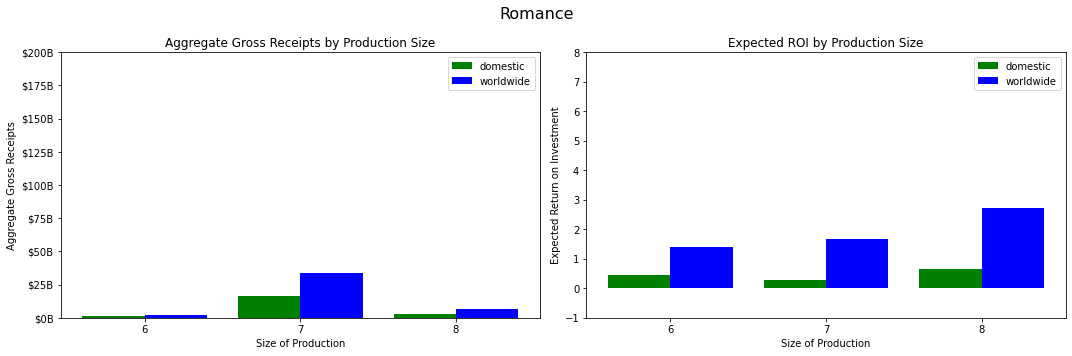

production_size   6    7  8
total            70  151  8


In [46]:
genre_graphs('Romance')

<h2>Descending ROI</h2>

<h4>Mystery, Horror, History</h4>
<p>In all of these genres, the lowest budget movies have the highest ROI, with the box office dominated by medium budget movies. However in both the Mystery and Horror genres, small budget movies make up a healthy proportion of the overall data set. The fact that the market share is relatively small for these low-budget movies, while the aggregate ROI is extremely large, suggests a winner-take-all market in which a few productions' enormous success compensates many times over for the lackluster performance of the majority of their peers.</p>

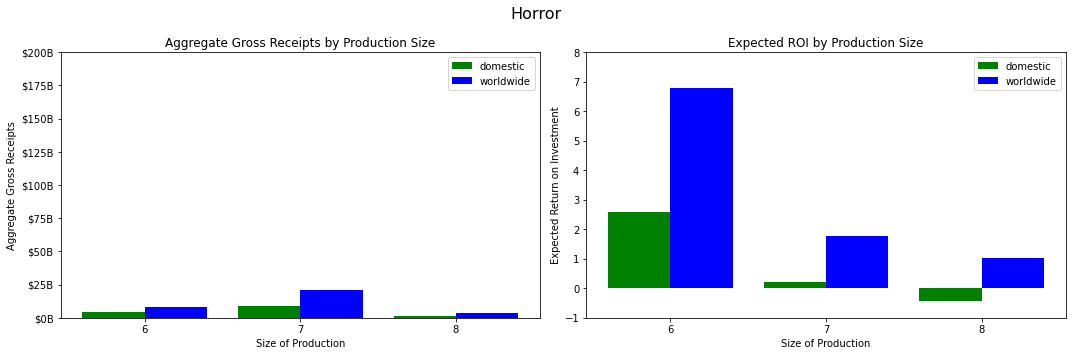

production_size   6   7  8
total            92  98  6


In [47]:
genre_graphs('Horror')

<h1>Conclusions</h1>

<p>The above visualizations suggest four business strategies.</p>
<ol>
    <li>Overall investment in a genre should be proportional to that genre's overall share of the worldwide market.</li>
    <li>The budget per production should be higher for genres where higher budgets correspond to increasing ROI</li>
    <li>The budget per production should be lower for genres where higher budgets corresponds to decreasing ROI.</li>
    <li>Unproven filmmakers should be given opportunities to succeed in these lower budget genres before moving on to big budget genres.</li> 
</ol>

<p>Since the Action and Adventure genres make up the largest share of the global market and show increasing ROI above $100 million dollars of investment, we should put the greatest share of our capital into a small number of these projects.</p>

<p>In a number of genres (Comedy, Drama, Romance, etc.),  movies under \$100 million dominate the box office, but films over \$100 million have a greater ROI. These films occupy a smaller share of the global box office than Action and Adventure, so studios might be tempted to make more of these movies for less money to hedge against failure. However, the fact that investment over \$100 million corresponds to higher expected returns should encourage us to spend more on a smaller number of these projects if we think it might make them more successful.</p>
    
<p>The Horror and Mystery Genres show the opposite logic--diminishing returns on investment as we move from 7 to 8 to 9 figure budgets. In these cases, we should prefer to keep costs low and maximize the number of projects that we produce. Younger, unproven filmmakers can be given opportunities in genres like Horror and Mystery, since highly successful movies can be made for under \$10 million. Filmmakers who succeed with these smaller budgets might go on to helm more capital-intensive productions in other genres. This is the career trajectory followed by Peter Jackson, who began his career with horror movies like Dead Alive, made for $3 million, and went on to direct the wildly successful Lord of the Rings movies.</p> 